In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import random
from keras.preprocessing import image
from PIL import Image
from tensorflow.keras.applications import ResNet50 
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import ResNet50 
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.layers import Layer
from tqdm import tqdm
import datetime
import shutil
import time

In [2]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [3]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
tf.config.list_physical_devices('GPU')


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
dataset = './dataset/images/'
imageLabels = './dataset/imageLabels.txt'
model_folder = './models/'
logs_folder = './logs/'

In [41]:
# Dataset settings
train_vol = 0.8

# Train settings
batch_size = 64
epochs = 50

In [7]:
categories = [
    "Pepperoni",
    "Bacon",
    "Mushrooms",
    "Onions",
    "Peppers",
    "Black olives",
    "Tomatoes",
    "Spinach",
    "Fresh basil",
    "Arugula",
    "Broccoli",
    "Corn",
    "Pineapple"
]

In [8]:
with open(imageLabels, 'r') as file:
    lines = file.readlines()
    y = []
    for line in lines:
        class_array = [int(num) for num in line.split()]
        y.append(class_array)
     
    y1=y
    y= np.array(y)    
        

print(y[0])


[0 0 0 1 1 0 0 0 0 0 0 0 0]


In [9]:
y.shape

(9213, 13)

In [10]:
from PIL import Image

In [11]:
def plot_images():
    
    plt.figure(figsize=(12, 12))
    indexes = [random.randint(0, 9213) for _ in range(12)]
    for i, index in enumerate(indexes):
        j= '{:05d}'.format(index)
        img_path = dataset+"/"+str(j)+'.jpg'
        img = image.load_img(img_path)
        img_arr = image.img_to_array(img)/255.0
        
        cat = []
        for k, label in enumerate(y[index-1]):
            if label == 1: 
                cat.append(categories[k])
                
                
        # Join categories into a single string
        if cat ==[]:
            cat_str = 'None'
        else :
            cat_str = ' & '.join(cat)        
        
        # Create Subplot and plot the images
        plt.subplot(4, 3, i+1)
        plt.imshow(img_arr)
        plt.axis('off')
        plt.text(0, -20, cat_str, fontsize=12, ha='left')
        
    plt.show()

        
plot_images()        
        
       

AttributeError: module 'keras.preprocessing.image' has no attribute 'load_img'

<Figure size 1200x1200 with 0 Axes>

In [12]:
image_names = ['{:05d}'.format(i) for i in range(1,9214)]

In [13]:
data_x = [tf.constant(np.array(Image.open(dataset + img + '.jpg').resize((224, 224)))) for img in image_names]

In [14]:
four_channel_images = []
for i in range(0,9213):
    if data_x[i].shape[2] == 4:
        four_channel_images.append(i)
print(four_channel_images)        

[3155, 3158, 3162, 3166, 3171, 3172, 3175, 3178, 3181, 3204, 3231, 3290, 3299, 3307, 3447, 3452, 3457, 3466, 3472, 3475, 3586, 3598, 3659, 3676, 3721, 3727, 3796, 3801, 3807, 3824, 3850]


In [15]:
#fixing 4 channel problem
for i in four_channel_images:
    j= '{:05d}'.format(i+1)
    rgba_image = Image.open(dataset + str(j) + '.jpg')
    rgb_image = rgba_image.convert("RGB")
    resized_image = rgb_image.resize((224, 224))
    image_array = np.array(resized_image)
    data_x[i]= image_array

In [42]:
train_dataset = tf.data.Dataset.from_tensor_slices((data_x, y))

In [43]:
def preprocess_data(img, label):
    img = tf.cast(img, tf.float32) / 255.0
    #img = tf.keras.applications.resnet50.preprocess_input(img)
    return img, label

In [44]:
train_dataset = train_dataset.map(preprocess_data)

In [45]:
len(train_dataset)

9213

In [46]:
for image, label in train_dataset.take(1):
    input_tensor = tf.keras.Input(shape=image.shape)

In [47]:
input_tensor


<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_2')>

In [48]:
labels = []
for i in range(1,9214):
        j= '{:05d}'.format(i)
        img_path = dataset+"/"+str(j)+'.jpg'
        cat=[]
        for k, label in enumerate(y[i-1]):
            if label == 1: 
                cat.append(categories[k])

        # Join categories into a single string
        if cat ==[]:
            cat_str = 'None'
        else :
            cat_str = ' & '.join(cat)    
            
        labels.append(cat_str)    
       

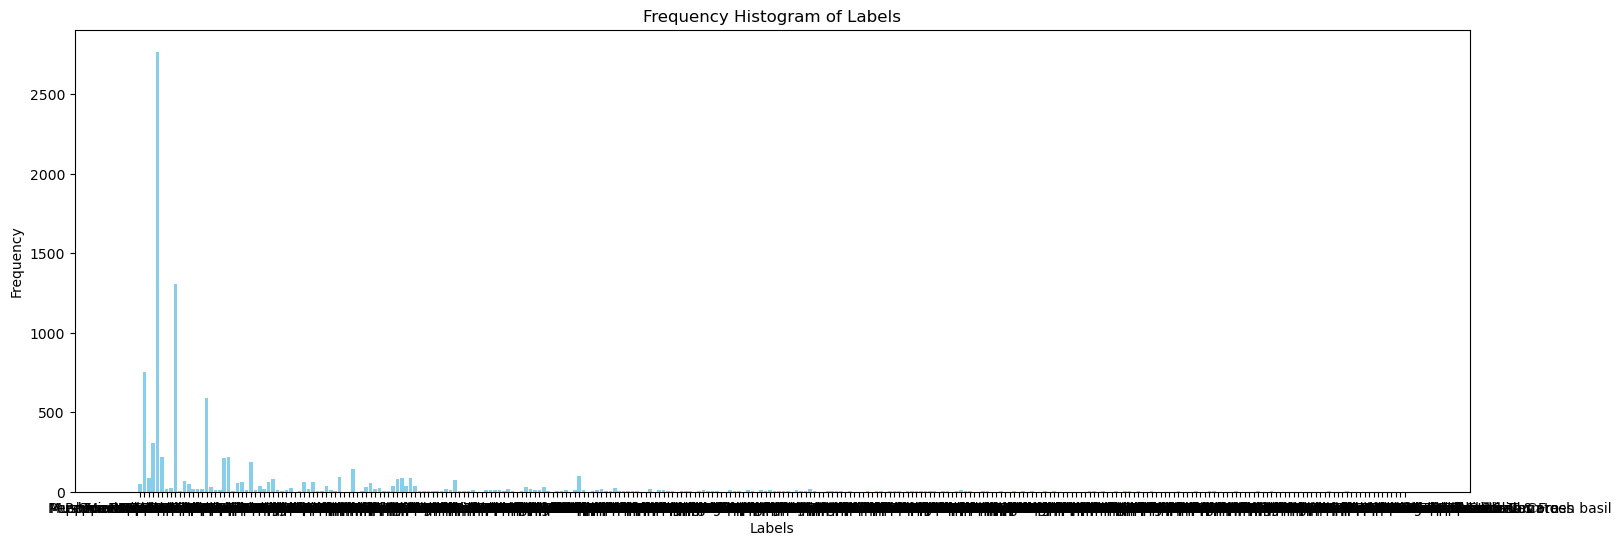

In [56]:
import matplotlib.pyplot as plt
from collections import Counter

# Visualise label distribution

label_counts = Counter(labels)
labels, frequencies = zip(*label_counts.items())

# Plot the histogram
plt.figure(figsize=(18, 6))
plt.bar(labels, frequencies, color='skyblue')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.title('Frequency Histogram of Labels')
plt.show()

In [49]:
# Split into train/validate
train_size = int(train_vol * len(train_dataset))

test_dataset = train_dataset.skip(train_size)
train_dataset = train_dataset.take(train_size)

In [50]:
# Batch data
train_dataset = train_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

In [60]:
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=(5, 5), activation="relu", input_shape=(224,224,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(13, activation='sigmoid'))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 220, 220, 16)      1216      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 110, 110, 16)     0         
 g2D)                                                            
                                                                 
 dropout_24 (Dropout)        (None, 110, 110, 16)      0         
                                                                 
 conv2d_17 (Conv2D)          (None, 106, 106, 32)      12832     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 53, 53, 32)       0         
 g2D)                                                            
                                                                 
 dropout_25 (Dropout)        (None, 53, 53, 32)       

In [63]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

AttributeError: module 'keras.api._v2.keras.metrics' has no attribute 'F1Score'

In [53]:
for batch in train_dataset:
    print(model.predict(batch[0])[0])
    break

2/2 [==============================] - 0s 434ms/step
[0.49871075 0.4391856  0.4800477  0.49354216 0.46977675 0.49982858
 0.46875212 0.4864121  0.533848   0.49007112 0.5328663  0.48748648
 0.5048225 ]


In [62]:
model_name = f'{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}-resnet_50.h5'

model_loc = f'{model_folder}{model_name}'
checkpoint = tf.keras.callbacks.ModelCheckpoint(model_loc, monitor='val_accuracy',
                             save_best_only=True, mode='max', verbose=1)

logs_loc = f'{logs_folder}{model_name}'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logs_loc, histogram_freq=1)

# Train model
run_hist = model.fit(train_dataset, validation_data=test_dataset,
                      epochs=epochs, batch_size=batch_size,
                      callbacks=[checkpoint, tensorboard_callback])

Epoch 1/50
116/116 [==============================] - 32s 271ms/step - loss: 0.3765 - macro_f1: 0.0501 - val_loss: 0.2594 - val_macro_f1: 0.0000e+00
Epoch 2/50
 90/116 [======================>.......] - ETA: 6s - loss: 0.3100 - macro_f1: 0.0157

KeyboardInterrupt: 

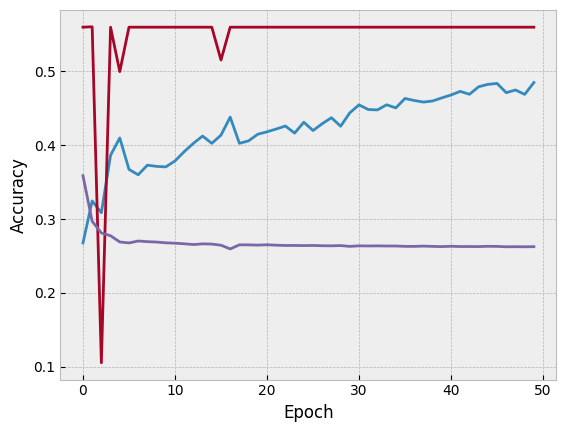

In [55]:
import matplotlib.pyplot as plt

# Plot accuracy and loss
plt.plot(run_hist.history['accuracy'], label='train')
plt.plot(run_hist.history['val_accuracy'], label='test')
plt.plot(run_hist.history['loss'], label='loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [56]:
def learning_curves(history):
    """Plot the learning curves of loss and macro f1 score 
    for the training and validation datasets.
    
    Args:
        history: history callback of fitting a tensorflow keras model 
    """
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    macro_f1 = history.history['accuracy']
    val_macro_f1 = history.history['val_accuracy']
    
    epochs = len(loss)

    style.use("bmh")
    plt.figure(figsize=(8, 8))

    plt.subplot(2, 1, 1)
    plt.plot(range(1, epochs+1), loss, label='Training Loss')
    plt.plot(range(1, epochs+1), val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')

    plt.subplot(2, 1, 2)
    plt.plot(range(1, epochs+1), macro_f1, label='Training accuracy')
    plt.plot(range(1, epochs+1), val_macro_f1, label='Validation accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Macro F1-score')
    plt.title('Training and Validation accuracy')
    plt.xlabel('epoch')

    plt.show()
    
    return loss, val_loss, macro_f1, val_macro_f1

In [57]:
import matplotlib.style as style

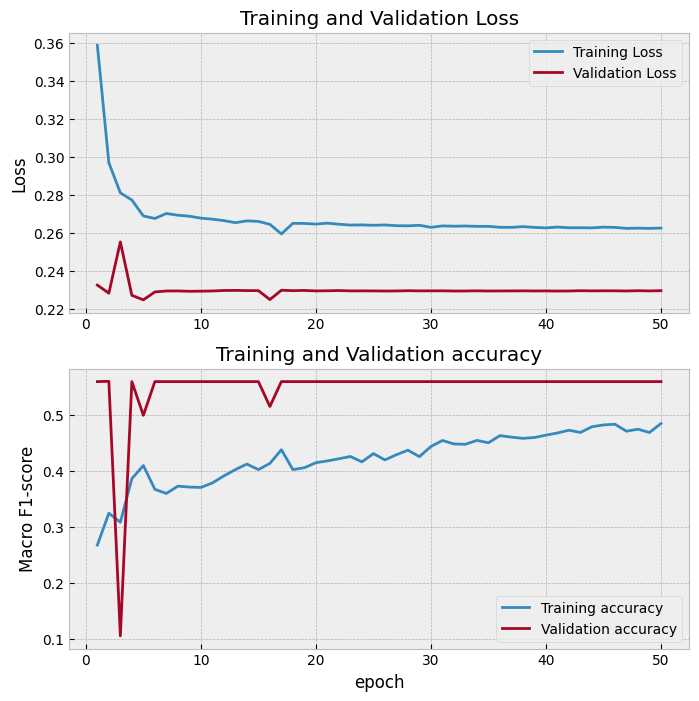

In [58]:
model_bce_losses, model_bce_val_losses, model_bce_macro_f1s, model_bce_val_macro_f1s = learning_curves(run_hist)
